In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from regression_tools.dftransformers import (
    ColumnSelector, Identity, FeatureUnion, MapFeature, Intercept)
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [29]:
def get_clean_referrals():
    referrals = pd.read_csv('data/2017_refs.csv', sep='|')
    referrals.drop(referrals.index[len(referrals)-1], inplace=True)
    referrals.columns = [col.lower().replace(' ', '_') for col in referrals.columns]
    referrals['refstat'].replace(['APPROVED', 'REJECTED', 'OTHER'], [1,0,0], inplace=True)
    referrals['dater'] =  pd.to_datetime(referrals['dater'], infer_datetime_format=True)
    referrals['regdate'] =  pd.to_datetime(referrals['regdate'], infer_datetime_format=True)
    referrals['sex'].replace(['F', 'M', 'I'], [0,1,0], inplace=True)
    referrals.rename(index=str, columns={"sex": "is_male", "refstat": "is_approve"}, inplace=True)
    referrals.drop(['plantype', 'patient', 'regdate', 'is_male', 'age', 'created_by', 'site_name'], axis = 1, inplace=True)
    referrals['priority_'].fillna('UNK', inplace=True)
    referrals['ppl'].replace(['Y', 'N', 'P'], [1,0,0], inplace=True)
    referrals['pat_req'].fillna('Y', inplace=True)
    referrals['pat_req'].replace(['Y', 'N'], [1,0], inplace=True)
    return referrals

## Data Cleaning Steps
* **referral_key** - lower case column title
* **refstat** - recoded to 1 (approved) and 0 (denied), rename to "is_approve"
* **dater** - change to datetime64[ns]
* **regdate** - change to datetime64[ns]
* **regdate** - change to datetime64[ns]
* **sex** - change to 0, 1 indicating male, rename to "is_male
* **age** - no change
* **plantype** - only one value - drop column
* **priority_** -- change nan to "unk"
* **create_by** - left alone
* **pat_req** - changed nans to Y, then Y and N to 1 and 0


In [30]:
referrals = get_clean_referrals()

In [31]:
pd.set_option('display.max_rows', 500)

In [32]:
pd.options.display.max_rows

500

## Feature Engineering

In [33]:
## EDA ideas
## can you do some sort of AUC with the categoricals. See what percent of levels contain what portion of denies?

In [34]:
## can you create pipelines for the variables (to do the cleaning more cleanly?)

## Features ideas
## CPT hierarchy - if cpt code then 1,0 in one of 10-20 MECE CPT groups
## create priority_UNK and priority_RET
## grouping of diagnoses


In [35]:
## Create a new feature for dollar amount of a referral
# costs = pd.read_csv('deduped_cost.csv')

# costs = costs.drop('Unnamed: 0', axis=1)

# cols_to_get_costs = ['cpt1', 'cpt2', 'cpt3', 'cpt4']

# ## function to lookup costs
# def get_cpt_cost(cols_to_change, df):
#     for name in cols_to_change:
#         df = pd.merge(df, costs, how='left', left_on=name, right_on='code')
#         df.rename(index=str, columns={"cost": ''.join([name, 'cost'])}, inplace=True)
#         df.drop('code', inplace=True, axis=1)
#     return df

# referrals = get_cpt_cost(cols_to_get_costs, referrals)

In [36]:
# referrals['cpt1cost'].fillna(0, inplace=True)
# referrals['cpt2cost'].fillna(0, inplace=True)
# referrals['cpt3cost'].fillna(0, inplace=True)
# referrals['cpt4cost'].fillna(0, inplace=True)

# referrals['total_cost'] = referrals['cpt1cost'] + referrals['cpt2cost'] + referrals['cpt3cost'] + referrals['cpt4cost']

In [37]:
class CustomScaler(BaseEstimator,TransformerMixin): 
    # note: returns the feature matrix with the binary columns ordered first  
    def __init__(self,bin_vars_index,cont_vars_index,copy=True,with_mean=True,with_std=True):
        self.scaler = StandardScaler(copy,with_mean,with_std)
        self.bin_vars_index = bin_vars_index
        self.cont_vars_index = cont_vars_index

    def fit(self, X, y=None):
        self.scaler.fit(X[:,self.cont_vars_index], y)
        return self

    def transform(self, X, y=None, copy=None):
        X_tail = self.scaler.transform(X[:,self.cont_vars_index],y,copy)
        return np.concatenate((X[:,self.bin_vars_index],X_tail), axis=1)

In [38]:
## create a new var that is a binned (by historical approval rates) version of another categorical variable
def get_binned_var(cat_var, target_var, df):
    df[cat_var].fillna('wasnull', inplace=True)
    temp_df = df.groupby(cat_var)[target_var].mean()
    temp_df = pd.pivot_table(df, values=target_var, index=cat_var, aggfunc='mean')
    df[(''.join([cat_var, 'hist']))] = df[cat_var].apply(lambda x: temp_df.loc[x])
    return df, temp_df

In [39]:
def get_binned_var_from_hist(df, cat_var, hist_lookup):
    wn = pd.Series(df['is_approve'].mean())
    wn.name = 'wasnull'
    hist_lookup.append(wn)
    df[cat_var].fillna('wasnull', inplace=True)
    df[(''.join([cat_var, 'hist']))] = df[cat_var].apply(lambda x: hist_lookup.loc[x][0] if x in hist_lookup.index else df['is_approve'].mean())
    return df

In [40]:
# get binned for ref_type, CPT (lowest of)
# get dummie for pat_req, priority_

In [177]:
def plotroc(FPR, TPR):
    roc_auc = auc(FPR, TPR)
    plt.figure()
    lw = 2
    plt.plot(FPR, TPR, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('ROC.png')

In [178]:
def plot_prec_aa(precs, aarates):
    plt.figure()
    lw = 2
    plt.plot(aarates, precs, color='red',
             lw=lw)
    plt.plot([0, 1], [0.98, 0.98], color='black', lw=lw, linestyle='--')
    plt.plot([.4, .4], [.9, 1], color='black', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.xlabel('Auto Approval Rate')
    plt.ylabel('Precision')
    plt.text(0.6, .99, 'Goal', color='green')
    plt.title('Auto-Approval rate & Precision')
    plt.savefig('AA_prec.png')

In [43]:
def standard_confusion_matrix(y_true, y_pred):
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_pred)
    return np.array([[tp, fp], [fn, tn]])

In [44]:
def get_binned_multiple(cols_to_bin, target_var, df):
    historical_dfs = []
    for col in cols_to_bin:
        df, new_hist_df = get_binned_var(col, target_var, df)
        
        historical_dfs.append((''.join([col, 'histdf'])))
    return df, historical_dfs

In [45]:
def ROC_curve(probabilities, labels):
    prob_vals = pd.DataFrame()
    prob_vals = pd.DataFrame({'probabilities':probabilities, 'labels':labels})
    prob_vals.sort_values('probabilities', inplace=True)
    prob_vals['prediction']=1
    lst_thresh = []
    lst_TPR = []
    lst_FPR = []
    for i in np.arange(prob_vals['probabilities'].count()):
        threshold = prob_vals['probabilities'].iloc[i]
        prob_vals.set_value(i, col='prediction', value=0)
        TPR = (prob_vals[(prob_vals['prediction']==1)&(prob_vals['labels']==1)]['labels'].sum())/(prob_vals['labels'].sum() if prob_vals['labels'].sum() > 0 else 1)
        FPR = (prob_vals[(prob_vals['prediction']==1)&(prob_vals['labels']==0)]['prediction'].sum())/(prob_vals[prob_vals['labels']==0]['labels'].count())
        lst_thresh.append(threshold)
        lst_TPR.append(TPR)
        lst_FPR.append(FPR)
    return lst_TPR, lst_FPR, lst_thresh

In [46]:
def get_prec_aa_prof(thresholds, y_true, y_proba):
    precs = []
    aarate = []
    n = len(y_true)
    for thresh in thresholds:
        tp, fp, fn, tn = standard_confusion_matrix(y_true, (y_proba > thresh).astype(int)).ravel()
        precs.append(tp/(tp + fp))
        aarate.append(tp/n)
    return precs, aarate

## EDA

In [47]:
CPT = pd.pivot_table(referrals, values='is_approve', index='cpt1', aggfunc={'count', 'mean', 'std'})
CPT.to_csv('cpt_app_rate.csv')
dol_bins = np.linspace(0,20000,41)

def get_app_rates_by_dollar(dollar_bins, referrals_df):
    rates = []
    for i in dollar_bins:
        rate = referrals[(referrals['total_cost']>i) & (referrals['total_cost']<(i+500))]['is_approve'].mean()
        rates.append(rate)
    return rates

In [48]:
# rates = get_app_rates_by_dollar(dol_bins, referrals)

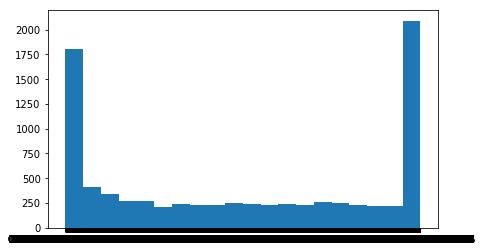

In [49]:
fig1 = plt.figure(figsize=(7,4))
ax11 = fig1.add_subplot(111)
ax11.hist(pd.pivot_table(referrals, values='is_approve', index='ref_prov', aggfunc='mean'), bins = 20);

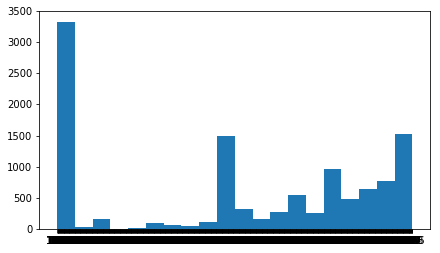

In [51]:
fig2 = plt.figure(figsize=(7,4))
ax21 = fig2.add_subplot(111)
ax21.hist(pd.pivot_table(referrals, values='referral_key', index='ref_to_prov', aggfunc='count'), bins=20);

## Train Test Split

In [52]:
## break data into train and test

test = referrals[referrals['dater']>'2017-08-31']
train = referrals[referrals['dater']<='2017-08-31']

In [53]:
## break train data into val and train_train
train_val = train[train['dater']>'2017-07-31']
train_train = train[train['dater']<='2017-07-31']

In [63]:
## create features based on train_train data

train_train, planname_hist = get_binned_var('planname', 'is_approve', train_train)

In [64]:
train_train, priority_hist = get_binned_var('priority_', 'is_approve', train_train)

In [65]:
train_train, ref_to_prov_hist = get_binned_var('ref_to_prov', 'is_approve', train_train)

In [66]:
train_train, ref_to_spec_hist = get_binned_var('ref_to_spec', 'is_approve', train_train)

In [67]:
train_train, ref_prov_hist = get_binned_var('ref_prov', 'is_approve', train_train)

In [68]:
train_train, ref_spec_hist = get_binned_var('ref_spec', 'is_approve', train_train)

In [69]:
train_train, ref_type_hist = get_binned_var('ref_type', 'is_approve', train_train)

In [70]:
train_train, diag_hist = get_binned_var('diag', 'is_approve', train_train)

In [71]:
train_train, cpt1hist = get_binned_var('cpt1', 'is_approve', train_train)

# train_train = get_binned_var_from_hist(train_train, 'cpt2', cpt1hist)
# train_train = get_binned_var_from_hist(train_train, 'cpt3', cpt1hist)
# train_train = get_binned_var_from_hist(train_train, 'cpt4', cpt1hist)

In [56]:
## apply historical features to validation data

train_val = get_binned_var_from_hist(train_val, 'planname', planname_hist)

In [57]:
train_val = get_binned_var_from_hist(train_val, 'priority_', priority_hist)

In [58]:
train_val = get_binned_var_from_hist(train_val, 'ref_to_prov', ref_to_prov_hist)

In [59]:
train_val = get_binned_var_from_hist(train_val, 'ref_to_spec', ref_to_spec_hist)

In [72]:
train_val = get_binned_var_from_hist(train_val, 'ref_prov', ref_prov_hist)

In [73]:
train_val = get_binned_var_from_hist(train_val, 'ref_spec', ref_spec_hist)

In [74]:
train_val = get_binned_var_from_hist(train_val, 'ref_type', ref_type_hist)

In [75]:
train_val = get_binned_var_from_hist(train_val, 'diag', diag_hist)

In [76]:
train_val = get_binned_var_from_hist(train_val, 'cpt1', cpt1hist)

In [82]:
## apply historical features to test data

test = get_binned_var_from_hist(test, 'planname', planname_hist)

In [83]:
test = get_binned_var_from_hist(test, 'priority_', priority_hist)

In [84]:
test = get_binned_var_from_hist(test, 'ref_to_prov', ref_to_prov_hist)

In [85]:
test = get_binned_var_from_hist(test, 'ref_to_spec', ref_to_spec_hist)

In [86]:
test = get_binned_var_from_hist(test, 'ref_prov', ref_prov_hist)

In [87]:
test = get_binned_var_from_hist(test, 'ref_spec', ref_spec_hist)

In [88]:
test = get_binned_var_from_hist(test, 'ref_type', ref_type_hist)

In [89]:
test = get_binned_var_from_hist(test, 'diag', diag_hist)

In [90]:
test = get_binned_var_from_hist(test, 'cpt1', cpt1hist)

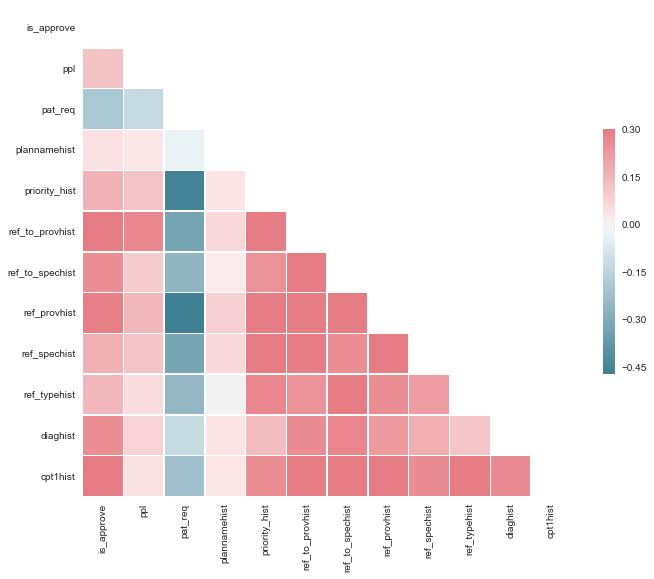

In [201]:
sns.set(style="white")

# Compute the correlation matrix
corr = train_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns_plot = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


fig = sns_plot.get_figure()
fig.savefig("imgs/corrheat.png")

In [91]:
test.corr()

,is_approve,ppl,pat_req,plannamehist,priority_hist,ref_to_provhist,ref_to_spechist,ref_provhist,ref_spechist,ref_typehist,diaghist,cpt1hist
is_approve,1.000000,0.109945,-0.180004,0.031880,0.145422,0.316998,0.247284,0.240451,0.171723,0.134503,0.163176,0.286657
ppl,0.109945,1.000000,-0.111452,-0.011087,0.111243,0.253621,0.083915,0.119764,0.103203,0.051261,0.056132,0.032213
pat_req,-0.180004,-0.111452,1.000000,-0.026201,-0.415240,-0.263501,-0.248797,-0.416776,-0.312104,-0.251379,-0.078874,-0.197653
plannamehist,0.031880,-0.011087,-0.026201,1.000000,0.029734,0.046562,0.017403,0.085440,0.063174,-0.002274,0.024740,0.022766
priority_hist,0.145422,0.111243,-0.415240,0.029734,1.000000,0.244027,0.234216,0.514673,0.379203,0.265683,0.087824,0.234389
ref_to_provhist,0.316998,0.253621,-0.263501,0.046562,0.244027,1.000000,0.518974,0.401163,0.309883,0.258100,0.190092,0.334607
ref_to_spechist,0.247284,0.083915,-0.248797,0.017403,0.234216,0.518974,1.000000,0.286455,0.267943,0.394309,0.234682,0.448974
ref_provhist,0.240451,0.119764,-0.416776,0.085440,0.514673,0.401163,0.286455,1.000000,0.607062,0.260438,0.156799,0.311230
ref_spechist,0.171723,0.103203,-0.312104,0.063174,0.379203,0.309883,0.267943,0.607062,1.000000,0.224223,0.142426,0.261637
ref_typehist,0.134503,0.051261,-0.251379,-0.002274,0.265683,0.258100,0.394309,0.260438,0.224223,1.000000,0.092340,0.318586


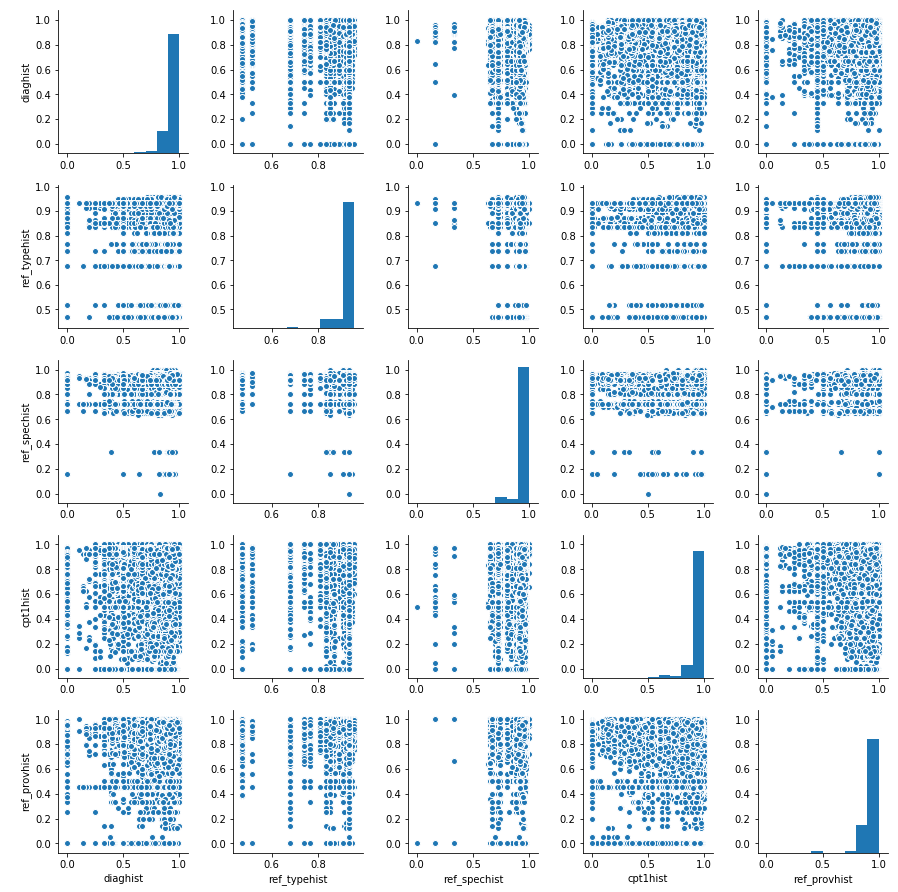

In [77]:
sns.pairplot(train_train[['diaghist', 'ref_typehist', 'ref_spechist', 'cpt1hist', 'ref_provhist']])

In [92]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 649283 entries, 1 to 2045022
Data columns (total 26 columns):
referral_key       649283 non-null object
is_approve         649283 non-null int64
dater              649283 non-null datetime64[ns]
planname           649283 non-null object
priority_          649283 non-null object
ref_to_prov        649283 non-null object
ref_to_spec        649283 non-null object
ref_prov           649283 non-null object
ref_spec           649283 non-null object
ref_type           649283 non-null object
ppl                649283 non-null int64
pat_req            649283 non-null int64
diag               649283 non-null object
cpt1               649283 non-null object
cpt2               263178 non-null object
cpt3               69666 non-null object
cpt4               35407 non-null object
plannamehist       649283 non-null float64
priority_hist      649283 non-null float64
ref_to_provhist    649283 non-null float64
ref_to_spechist    649283 non-null float64
ref_

In [79]:
cols_all = ['plannamehist', 'priority_hist', 'ref_to_provhist', 'ref_to_spechist', 'ref_provhist', 'ref_spechist', 'ref_typehist', 'diaghist', 'cpt1hist']

In [80]:
cols_select = ['ref_to_provhist', 'ref_typehist', 'diaghist', 'cpt1hist']

In [151]:
cols_few1 = ['ref_to_provhist']

In [166]:
cols_few2 = ['ref_to_provhist', 'cpt1hist']

In [156]:
## Split train_train into y and x
y_train_train = train_train['is_approve']
x_train_train = train_train[cols_all]
x_train_train_few = train_train[cols_select]

In [157]:
## Split train_val into y and x
y_train_val = train_val['is_approve']
x_train_val = train_val[cols_all]
x_train_val_few = train_val[cols_select]

In [169]:
## Split test into y and x
y_test = test['is_approve']
x_test = test[cols_all]
x_test_few = test[cols_select]
x_test_few2 = test[cols_few2]

In [ ]:
thresholds = np.linspace(0,1,101)

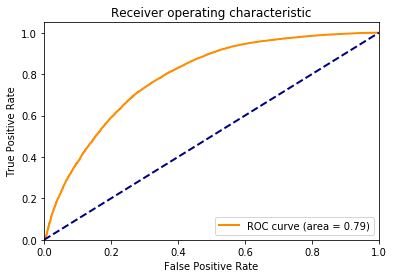

In [179]:
## All in - all vars, no balance
modellog_nobal = LogisticRegression()
modellog_nobal.fit(x_train_train, y_train_train)
y_train_val_proba_nobal = modellog_nobal.predict_proba(x_train_val)[:,1]
FPR_nobal, TPR_nobal, thresholds_nobal = roc_curve(y_train_val, y_train_val_proba_nobal)

plotroc(FPR_nobal, TPR_nobal)

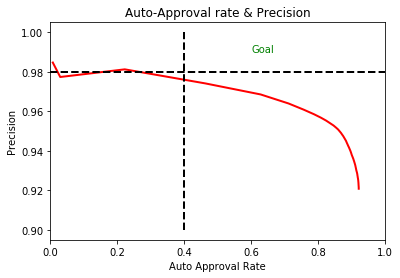

In [180]:
precisionsnobal, aaratesnobal = get_prec_aa_prof(thresholds, y_train_val, y_train_val_proba_nobal)
plot_prec_aa(precisionsnobal, aaratesnobal)

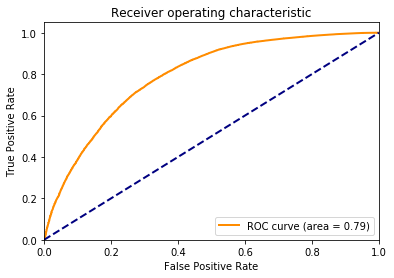

In [181]:
## All in - balanced - all vars, balanced
modellog = LogisticRegression(class_weight='balanced')
modellog.fit(x_train_train, y_train_train)
y_train_val_pred = modellog.predict(x_train_val)
y_train_val_proba = modellog.predict_proba(x_train_val)[:,1]
FPR, TPR, thresholds = roc_curve(y_train_val, y_train_val_proba)

plotroc(FPR, TPR)

In [132]:
modellog.coef_

array([[ 6.34659183, -3.81021211,  6.93896289, -1.01010367,  4.90587851,
        -1.79107052,  2.1600725 ,  5.10851421,  4.95640621]])

In [133]:
modellog_nine.coef_

array([[ 3.80004525, -5.71060146,  5.92860168, -0.92742709,  4.25790049,
        -1.75292989,  2.62652509,  4.41626533,  4.0501438 ]])

In [136]:
modellog_three.coef_

array([[ 3.56561018, -5.68231842,  5.92643321, -0.91829384,  4.24359093,
        -1.73578826,  2.60564441,  4.41074242,  4.04563006]])

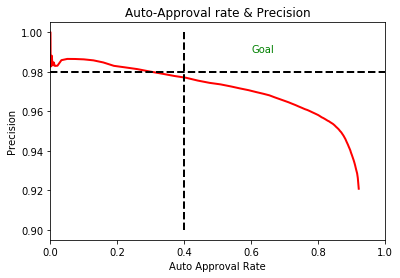

In [183]:
#precisions, aarates = get_prec_aa_prof(thresholds, y_train_val, y_train_val_proba)
plot_prec_aa(precisions, aarates)

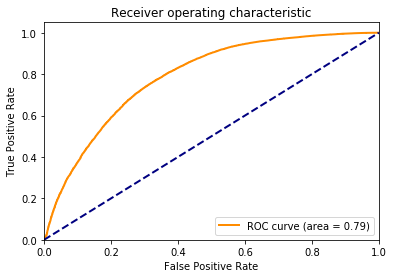

In [130]:
## Lasso in Logistic - C=0.9
modellog_nine = LogisticRegression(penalty='l1', C=.9)
modellog_nine.fit(x_train_train, y_train_train)
y_train_val_proba_nine = modellog_nine.predict_proba(x_train_val)[:,1]
FPR_nine, TPR_nine, thresholds_nine = roc_curve(y_train_val, y_train_val_proba_nine)

plotroc(FPR_nine, TPR_nine)

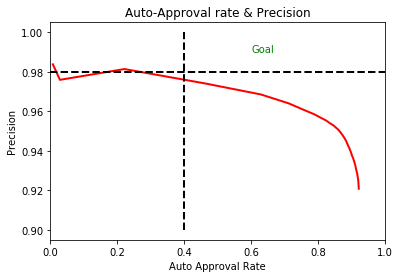

In [140]:
precisions_nine, aarates_nine = get_prec_aa_prof(thresholds, y_train_val, y_train_val_proba_nine)
plot_prec_aa(precisions_nine, aarates_nine)

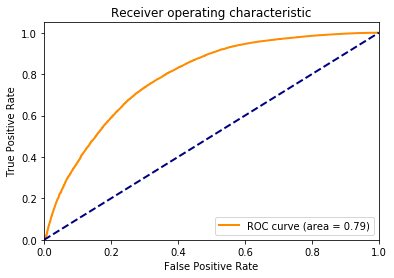

In [184]:
## Lasso in Logistic - C=0.3
# modellog_three = LogisticRegression(penalty='l1', C=.3)
# modellog_three.fit(x_train_train, y_train_train)
# y_train_val_proba_three = modellog_three.predict_proba(x_train_val)[:,1]
# FPR_three, TPR_three, thresholds_three = roc_curve(y_train_val, y_train_val_proba_three)

plotroc(FPR_three, TPR_three)

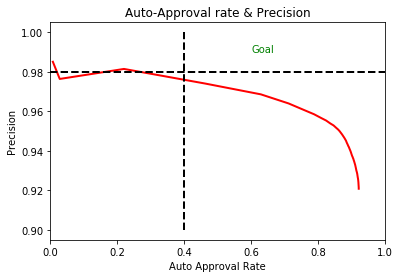

In [185]:
#precisions_three, aarates_three = get_prec_aa_prof(thresholds, y_train_val, y_train_val_proba_three)
plot_prec_aa(precisions_three, aarates_three)

In [144]:
## Downsample the "approve" class
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_sample(x_train_train, y_train_train)

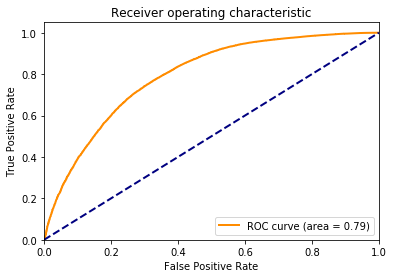

In [186]:
## Logistic with downsampled "approves" to train with
# modellog_ds = LogisticRegression()
# modellog_ds.fit(X_resampled, y_resampled)
# y_train_val_pred_ds = modellog_ds.predict(x_train_val)
# y_train_val_proba_ds = modellog_ds.predict_proba(x_train_val)[:,1]
# FPR_ds, TPR_ds, thresholds_ds = roc_curve(y_train_val, y_train_val_proba_ds)

plotroc(FPR_ds, TPR_ds)

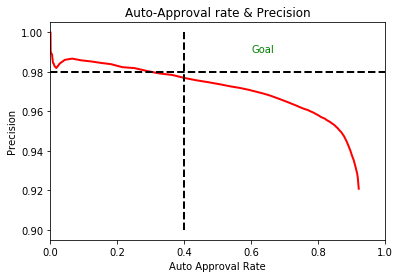

In [187]:
#precisions_ds, aarates_ds = get_prec_aa_prof(thresholds, y_train_val, y_train_val_proba_ds)
plot_prec_aa(precisions_ds, aarates_ds)

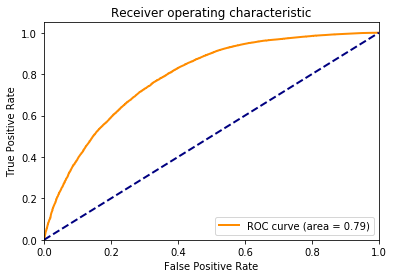

In [188]:
## Logistic with selected variables - 'ref_to_provhist', 'ref_typehist', 'diaghist', 'cpt1hist'
# modellog_few = LogisticRegression()
# modellog_few.fit(x_train_train_few, y_train_train)
# y_train_val_proba_few = modellog_few.predict_proba(x_train_val_few)[:,1]
# FPR_few, TPR_few, thresholds_few = roc_curve(y_train_val, y_train_val_proba_few)

plotroc(FPR_few, TPR_few)

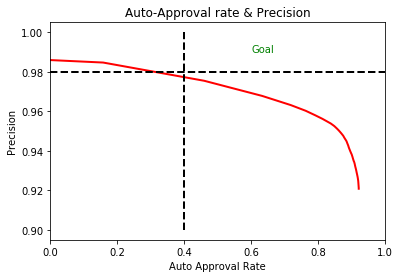

In [189]:
#precisions_few, aarates_few = get_prec_aa_prof(thresholds, y_train_val, y_train_val_proba_few)
plot_prec_aa(precisions_few, aarates_few)

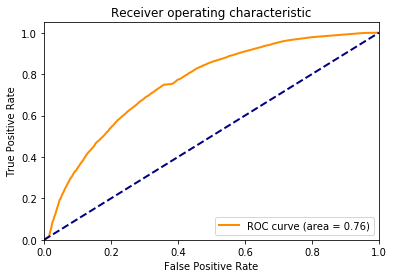

In [190]:
# cols_few1 = ['ref_to_provhist']
# x_train_train_few1 = train_train[cols_few1]
# x_train_val_few1 = train_val[cols_few1]

# ## Logistic with selected variables - ref_to_provhist
# modellog_few1 = LogisticRegression()
# modellog_few1.fit(x_train_train_few1, y_train_train)
# y_train_val_proba_few1 = modellog_few1.predict_proba(x_train_val_few1)[:,1]
# FPR_few1, TPR_few1, thresholds_few1 = roc_curve(y_train_val, y_train_val_proba_few1)

plotroc(FPR_few1, TPR_few1)

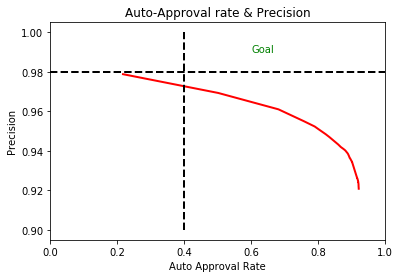

In [191]:
#precisions_few1, aarates_few1 = get_prec_aa_prof(thresholds, y_train_val, y_train_val_proba_few1)
plot_prec_aa(precisions_few1, aarates_few1)

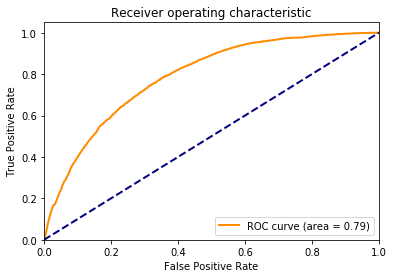

In [192]:
# cols_few2 = ['ref_to_provhist', 'cpt1hist']
# x_train_train_few2 = train_train[cols_few2]
# x_train_val_few2 = train_val[cols_few2]

# ## Logistic with selected variables - ref_to_provhist
# modellog_few2 = LogisticRegression()
# modellog_few2.fit(x_train_train_few2, y_train_train)
# y_train_val_proba_few2 = modellog_few2.predict_proba(x_train_val_few2)[:,1]
# FPR_few2, TPR_few2, thresholds_few2 = roc_curve(y_train_val, y_train_val_proba_few2)

plotroc(FPR_few2, TPR_few2)

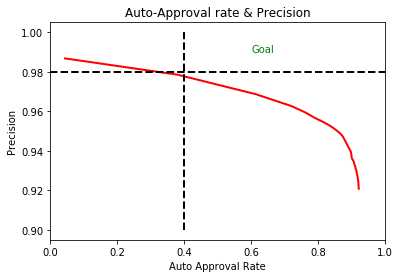

In [193]:
#precisions_few2, aarates_few2 = get_prec_aa_prof(thresholds, y_train_val, y_train_val_proba_few2)
plot_prec_aa(precisions_few2, aarates_few2)

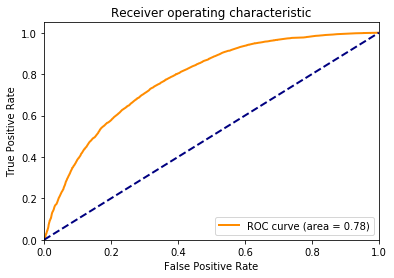

In [194]:
## Logistic with selected variables - ref_to_provhist
# y_test_proba_few2 = modellog_few2.predict_proba(x_test_few2)[:,1]
# FPR_few2_test, TPR_few2_test, thresholds_few2_test = roc_curve(y_test, y_test_proba_few2)

plotroc(FPR_few2_test, TPR_few2_test)

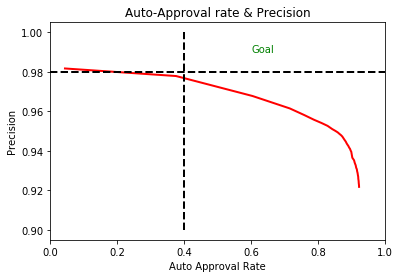

In [195]:
#precisions_few2_test, aarates_few2_test = get_prec_aa_prof(thresholds, y_test, y_test_proba_few2)
plot_prec_aa(precisions_few2_test, aarates_few2_test)

In [ ]:
precisions, aarates = get_prec_aa_prof(thresholds, y_train_val, y_train_val_proba_dsfew)

In [ ]:
plot_prec_aa(precisions, aarates)